<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function,
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving Capture.JPG to Capture.JPG

Upload Style Image


Saving 17MALE~1.PNG to 17MALE~1 (1).PNG
Content Path: <_io.BytesIO object at 0x7dcd585627a0>
Style Path: <_io.BytesIO object at 0x7dcd3eaff150>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


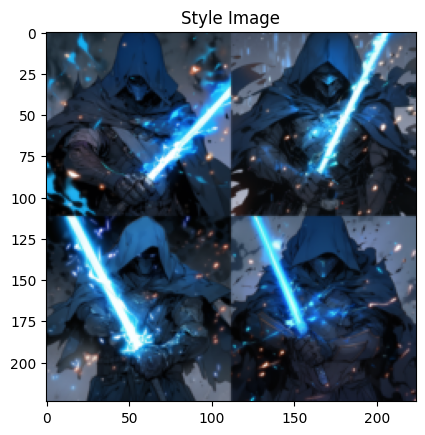

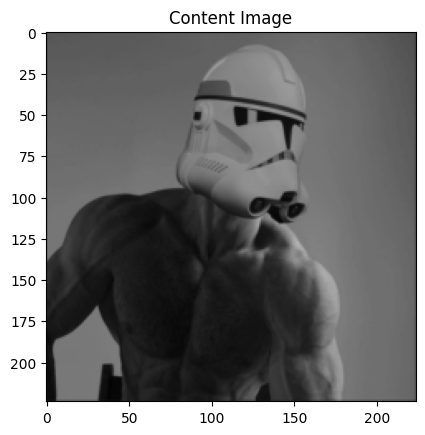

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_inds = [vgg_names.index("conv4_2")]
style_inds = [vgg_names.index("conv1_1"), vgg_names.index("conv2_1"), vgg_names.index("conv3_1"), vgg_names.index("conv4_1"), vgg_names.index("conv5_1")]

# Create the vgg network in eval mode with our forward method that returns the outputs of the intermediate layers we requested
style_vgg = VGGIntermediate(style_inds).cuda().eval()
content_vgg = VGGIntermediate(content_inds).cuda().eval()

# Cache the outputs of the content and style layers for their respective images
style_layers = style_vgg(style_image)
content_layers = content_vgg(content_image)

<ipython-input-13-4e86d2def5ec>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-13-4e86d2def5ec>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


___

### Part 2
Create a classes for the style and content loss

**TODO:**

**DONE:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [ ]:
def gram_matrix(input:torch.Tensor) -> torch.Tensor:
  batch, channels, height, width = input.shape
  features = input.view(batch*channels, height*width)
  orthobasis = features @ features.t()
  normal = orthobasis / (batch*channels*height*width)
  return normal

class ContentLoss(nn.Module):
  def __init__(self, inds, img):
    super(ContentLoss, self).__init__()
    self.vgg = VGGIntermediate(inds).cuda()
    activations: dict = self.vgg(img)
    self.P = []
    for key in activations.keys():
      Fl = activations[key].detach()
      self.P.append(Fl)

  def forward(self, x):
    activations: dict = self.vgg(x)
    loss = 0
    for l, key in enumerate(activations.keys()):
      Fl = activations[key]
      loss += torch.sum( (Fl - self.P[l])**2 ) / Fl.numel()
    loss *= 0.5
    return loss

class StyleLoss(nn.Module):
  def __init__(self, inds, img):
    super(StyleLoss, self).__init__()
    self.vgg = VGGIntermediate(inds).cuda()
    activations: dict = self.vgg(img)
    self.gees = []
    for key in activations.keys():
      Fl = activations[key].detach()
      self.gees.append(gram_matrix(Fl))

  def forward(self, x):
    activations: dict = self.vgg(x)
    loss = 0
    for l, key in enumerate(activations.keys()):
      G = gram_matrix(activations[key])
      loss += F.mse_loss( G, self.gees[l] ) / len(activations)
    return loss

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison
content_obj = ContentLoss(content_inds, content_image)

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
style_obj = StyleLoss(style_inds, style_image)

<ipython-input-13-4e86d2def5ec>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-13-4e86d2def5ec>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!



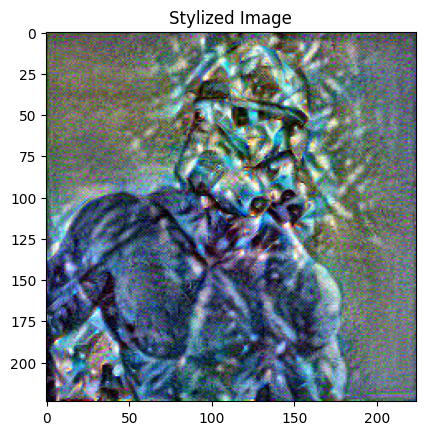

In [ ]:
# Start with a copy of the content image
img = content_image.clone()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors
optimizer = optim.Adam([img.requires_grad_()], lr=0.1)

losses = []
alpha = 1.0
beta = 10000.0
num_epochs = 500
loop_rate = 50
loop = tqdm(total=num_epochs//loop_rate+1, position=0, leave=False)
for epoch in range(num_epochs):
  optimizer.zero_grad()

  content_loss = content_obj(img) * alpha
  style_loss = style_obj(img) * beta
  loss = style_loss + content_loss
  if epoch % loop_rate == 0:
    losses.append(loss.item())
    loop.set_description(f'epoch:{epoch}, \style_loss:{style_loss.item()}, \content_loss:{content_loss.item()}')
    loop.update(1)

  loss.backward()
  optimizer.step()

  img.data.clamp_(0,1)

loop.close()

# Show the image
plt.figure()
display(img, title='Stylized Image')

### Part 4

**TODO:**

**DONE:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

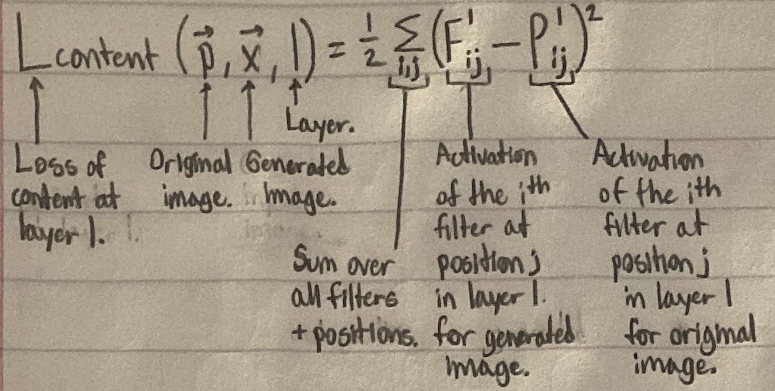

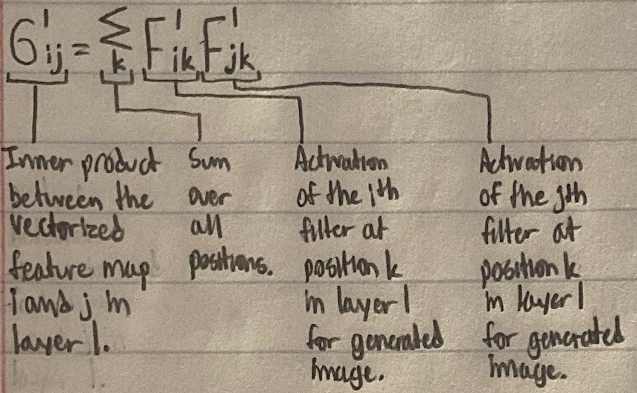

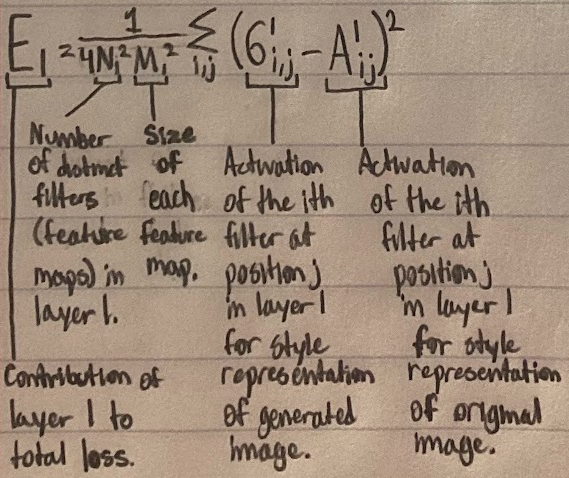

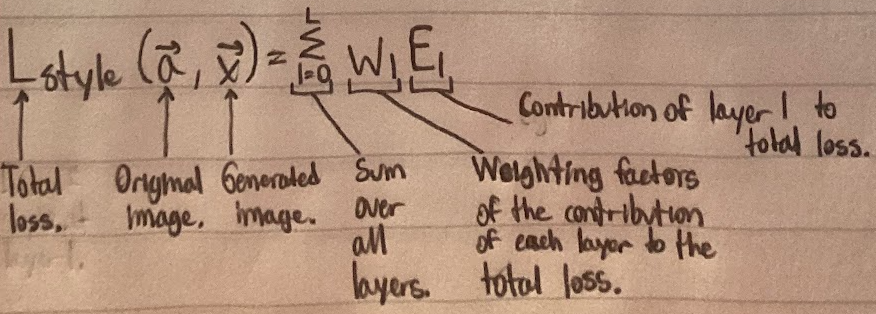